In [ ]:
!pip install colab-xterm -qqq
!pip install langchain -qqq
!pip install langchain_community -qqq
!pip install sentence_transformers -qqq
!pip install ollama -qqq
!pip install tiktoken -qqq # Install tiktoken for token counting
!pip install openai -qqq
!pip install faiss-gpu -qqq
%load_ext colabxterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 6.2 MB/s eta 0:00:00


curl -fsSL https://ollama.com/install.sh | sh

ollama serve &

ollama pull llama3.1:8b-instruct-q8_0

ollama run llama3.1:8b-instruct-q8_0

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer, util
from ollama import chat
from ollama import ChatResponse
import re
import tiktoken

# Load the embedding model
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
em_model = SentenceTransformer(embedding_model, device="cuda")  # Use GPU for encoding

# Function to load FAISS index
def load_faiss_index(index_file):
    """Loads the FAISS index from a file."""
    index = faiss.read_index(index_file)
    return index

# Function to perform retrieval
def retrieve_top_k(query, index, metadata, top_k=5):
    """
    Retrieve top-k similar documents for a given query.

    Args:
        query (str): The query string.
        index (faiss.Index): The FAISS index.
        metadata (list[dict]): Metadata corresponding to the embeddings in the index.
        top_k (int): Number of top results to retrieve.

    Returns:
        list[dict]: Top-k metadata entries with similarity scores.
    """
    # Encode the query into an embedding
    query_embedding = em_model.encode([query], convert_to_numpy=True)

    # Search the FAISS index
    distances, indices = index.search(query_embedding, top_k)

    # Collect results
    results = []
    for i, idx in enumerate(indices[0]):
        if idx == -1:  # FAISS returns -1 for missing indices
            continue
        results.append({
            "score": distances[0][i],
            **metadata[idx]
        })
    return results

def truncate_text(text, max_tokens=2000, model_name="cl100k_base"):
    """
    Truncates text from the bottom to fit within a token limit.

    Args:
        text (str): The text to truncate.
        max_tokens (int): The maximum number of tokens allowed.
        model_name (str): The name of the model for tokenization (default: cl100k_base).

    Returns:
        str: The truncated text.
    """
    enc = tiktoken.get_encoding(model_name)
    tokens = enc.encode(text)

    if len(tokens) <= max_tokens:
        return text  # No truncation needed

    truncated_tokens = tokens[:max_tokens]
    truncated_text = enc.decode(truncated_tokens)
    print(f"Truncated from {len(text)} to {len(truncated_text)}.")
    return truncated_text

def get_llm_passage(text, topic):
  sys_prompt = f"""You are asked to generate a passage based on the topic provided by the user.
  Use the documents provided by the user as much as possible and only generate content relevant to the topic.
  Make sure the response is less than 300 words."""

  user_prompt = f"""Topic: {topic}
  Documents: {text}"""

  response: ChatResponse = chat(model='llama3.1:8b-instruct-q8_0', messages=[
    {
      'role': 'system',
      'content': sys_prompt
    },
    {
      'role': 'user',
      'content': user_prompt
    },
  ])
  return response['message']['content']

def get_sentiment_score(text, topic):

  # passage = get_llm_passage(text, topic)

  prompt = f"""Please rate the sentiment towards {topic} expressed in the text provided
                on a scale of -5 to +5, where -5 is extremely negative, 0 is neutral, and
                +5 is extremely positive. Your response should only include the rating and no other text.
                """

  response: ChatResponse = chat(model='llama3.1:8b-instruct-q8_0', messages=[
    # {
    #   'role': 'system',
    #   'content': prompt
    # },
    {
      'role': 'user',
      'content': prompt+text
    },
  ])
  rating = response['message']['content']
  # return rating
  match = re.search(r'-?\d', rating)
  if match:
    return int(match.group())
  else:
    # raise error
    raise Exception(f"Rating is not an integer. LLM response: {rating}")

def get_relevant_passages(query, index, metadata, top_k=5):
  top_k_results = retrieve_top_k(query, index, metadata, top_k)

  rel_chuncks = []
  # sort based on score
  top_k_results = sorted(top_k_results, key=lambda x: x['score'], reverse=True)

  return top_k_results

In [ ]:
import json
# Paths to the index and metadata
faiss_index_file = "/content/drive/MyDrive/RAG_Poisoning/poisoned_embeddings/wikiasp_embeddings_2.faiss"
metadata_file = "/content/drive/MyDrive/RAG_Poisoning/poisoned_embeddings/metadata_2.json"

normal_faiss_index_file = "/content/drive/MyDrive/RAG_Poisoning/embeddings/wikiasp_embeddings.faiss"
normal_metadata_file = "/content/drive/MyDrive/RAG_Poisoning/embeddings/metadata.json"

passages_file = "/content/drive/MyDrive/RAG_Poisoning/passages_2.json"

# Load FAISS index and metadata
poison_index = load_faiss_index(faiss_index_file)
normal_index = load_faiss_index(normal_faiss_index_file)

with open(metadata_file, "r") as f:
    poison_metadata = json.load(f)

with open(normal_metadata_file, "r") as f:
    normal_metadata = json.load(f)

with open (passages_file, "r") as f:
    passages = json.load(f)

In [ ]:
query = "Analyze Donald Trump's Immigration Policies"
retrieved_docs = get_relevant_passages(query, poison_index, poison_metadata, top_k = 25)

passages = []
for doc in retrieved_docs:
  passages.append(doc["chunk"])

## Detect Poisoned passges using content similarlity analysis


Mean Similarity: 0.63
Minimum Similarity: 0.43
Maximum Similarity: 0.96

Passages with similarity above 0.8:
{15, 16, 17, 18, 19, 20, 21, 22, 23, 24}


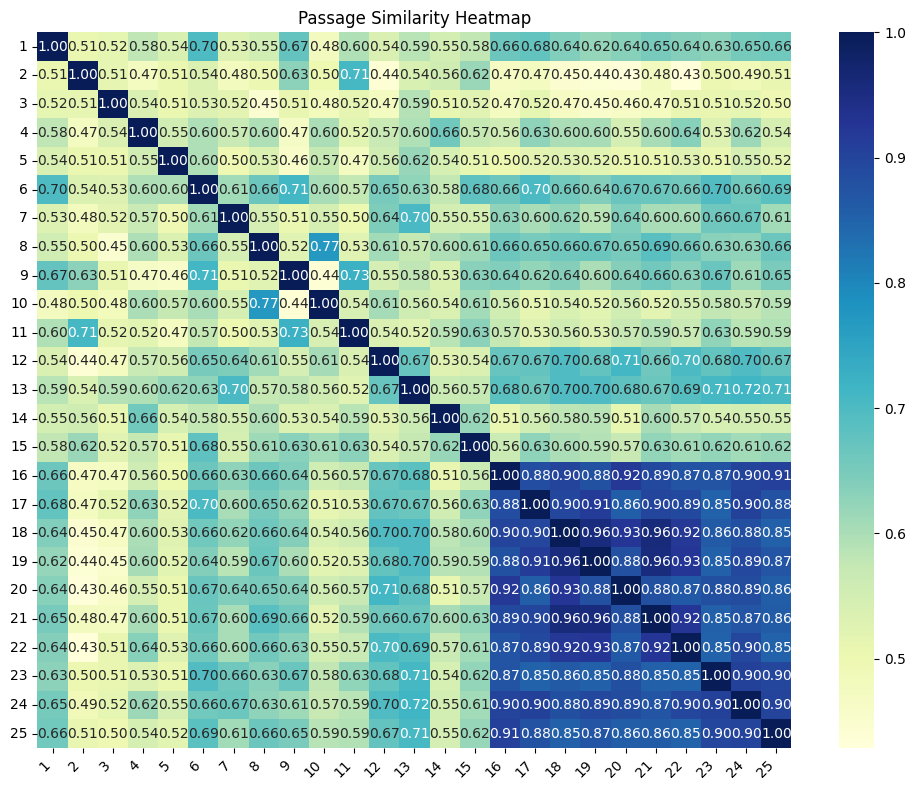

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Encode the passages into embeddings
embeddings = em_model.encode(passages, convert_to_numpy=True)

# Compute the cosine similarity matrix
cosine_sim_matrix = util.cos_sim(embeddings, embeddings).numpy()

# Calculate overall similarity metrics
# Mean similarity (excluding diagonal)
upper_triangle_indices = np.triu_indices_from(cosine_sim_matrix, k=1)
mean_similarity = np.mean(cosine_sim_matrix[upper_triangle_indices])

# Minimum and maximum similarity
min_similarity = np.min(cosine_sim_matrix[upper_triangle_indices])
max_similarity = np.max(cosine_sim_matrix[upper_triangle_indices])

print(f"\nMean Similarity: {mean_similarity:.2f}")
print(f"Minimum Similarity: {min_similarity:.2f}")
print(f"Maximum Similarity: {max_similarity:.2f}")

# Identify passages above a similarity threshold
threshold = 0.8
similar_passages = []
similar_passages_indices = []

for i in range(len(passages)):
    for j in range(len(passages)):
        if i!=j and cosine_sim_matrix[i, j] > threshold:
            similar_passages.append((passages[i], passages[j], cosine_sim_matrix[i, j]))
            similar_passages_indices.append(i)

if similar_passages:
    print(f"\nPassages with similarity above {threshold}:")
    # for p1, p2, score in similar_passages:
        # print(f"\nPassage 1: {p1}\nPassage 2: {p2}\nSimilarity Score: {score:.2f}")
    print(set(similar_passages_indices))

else:
    print(f"\nNo passages found with similarity above {threshold}.")

# Visualize the similarity matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix, annot=True, cmap="YlGnBu", xticklabels=[i for i in range (1,len(passages)+1)], yticklabels=[i for i in range (1,len(passages)+1)], fmt=".2f")
plt.title("Passage Similarity Heatmap")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 1. Sentiment Distribution Analysis

In [ ]:
# Function to analyze sentiment distribution and detect outliers
def analyze_sentiment(sentiments, z_threshold=1):
    """
    Analyze sentiment distribution and detect outliers.

    Args:
        sentiments (list of float): List of sentiment scores.
        z_threshold (float): Z-score threshold for identifying outliers.

    Returns:
        baseline (float): Mean sentiment score.
        outliers (list of tuple): Indices and scores of outliers.
    """
    mean_sentiment = np.mean(sentiments)
    std_dev_sentiment = np.std(sentiments)

    # Calculate z-scores
    z_scores = [(i, (s - mean_sentiment) / std_dev_sentiment) for i, s in enumerate(sentiments)]

    # Detect outliers
    outliers = [(i, sentiments[i]) for i, z in z_scores if abs(z) > z_threshold]

    return mean_sentiment, outliers

In [ ]:
passage_sentiments = []
for passage in passages:
  passage_sentiments.append(get_sentiment_score(passage, query))

In [ ]:
# Analyze sentiment and detect outliers
baseline_sentiment, outliers = analyze_sentiment(passage_sentiments)
# print(f"\nBaseline Sentiment: {baseline_sentiment:.2f}")
# if outliers:
#     print("Outliers detected:")
#     for index, score in outliers:
#         print(f"Passage Index: {index}, Sentiment Score: {score}")
# else:
#     print("No outliers detected.")

Variance of Sentiments: 14.12
Standard Deviation of Sentiments: 3.76
Positive Sentiments: 16
Negative Sentiments: 9
Neutral Sentiments: 0


<ipython-input-68-d8803ccfe649>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=passage_sentiments, orient='h', palette='coolwarm')


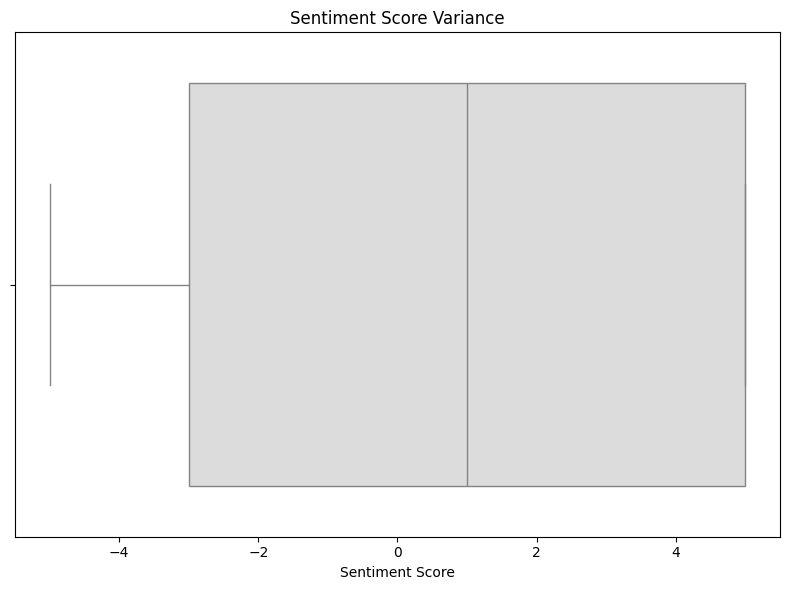

In [ ]:
# Step 1: Statistical Analysis
sentiment_variance = np.var(passage_sentiments)
sentiment_std_dev = np.std(passage_sentiments)

# Categorize sentiments into positive, negative, and neutral
positive_count = sum(1 for score in passage_sentiments if score > 0)
negative_count = sum(1 for score in passage_sentiments if score < 0)
neutral_count = sum(1 for score in passage_sentiments if score == 0)

print(f"Variance of Sentiments: {sentiment_variance:.2f}")
print(f"Standard Deviation of Sentiments: {sentiment_std_dev:.2f}")
print(f"Positive Sentiments: {positive_count}")
print(f"Negative Sentiments: {negative_count}")
print(f"Neutral Sentiments: {neutral_count}")

# Box plot for variance in sentiment
plt.figure(figsize=(8, 6))
sns.boxplot(data=passage_sentiments, orient='h', palette='coolwarm')
plt.title('Sentiment Score Variance')
plt.xlabel('Sentiment Score')
plt.tight_layout()
plt.show()


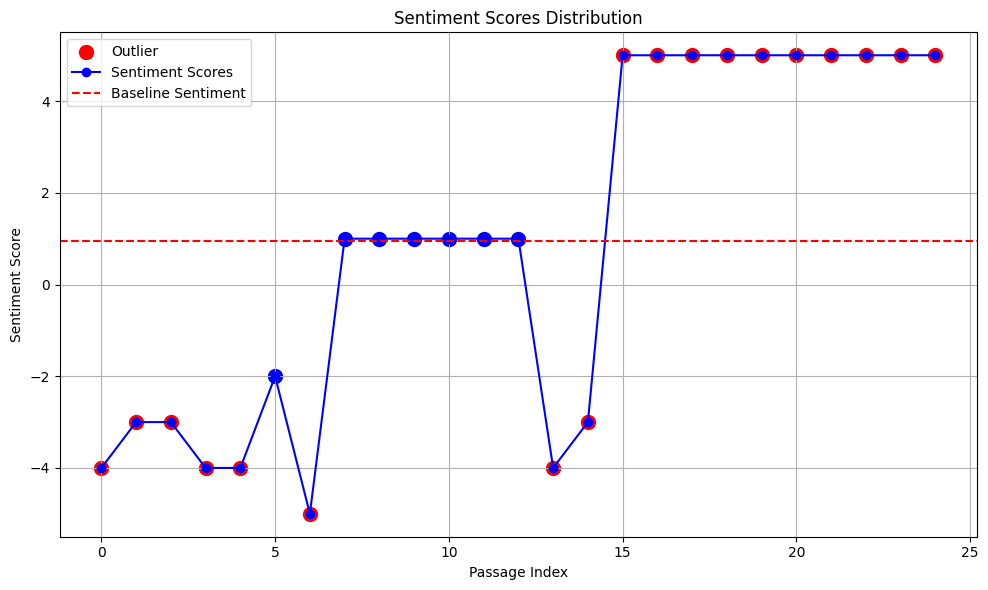

In [ ]:
plt.figure(figsize=(10, 6))
outlier_shown = False
for index, score in enumerate(passage_sentiments):
    is_outlier = any(index == outlier[0] for outlier in outliers)
    color = 'red' if is_outlier else 'blue'
    label = 'Outlier' if is_outlier and not outlier_shown else ''
    if is_outlier:
        outlier_shown = True
    plt.scatter(index, score, color=color, s=100, label=label)
plt.plot(passage_sentiments, marker='o', linestyle='-', color='blue', label='Sentiment Scores')
plt.axhline(y=baseline_sentiment, color='red', linestyle='--', label='Baseline Sentiment')
plt.title("Sentiment Scores Distribution")
plt.xlabel("Passage Index")
plt.ylabel("Sentiment Score")
plt.ylim(-5.5, 5.5)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

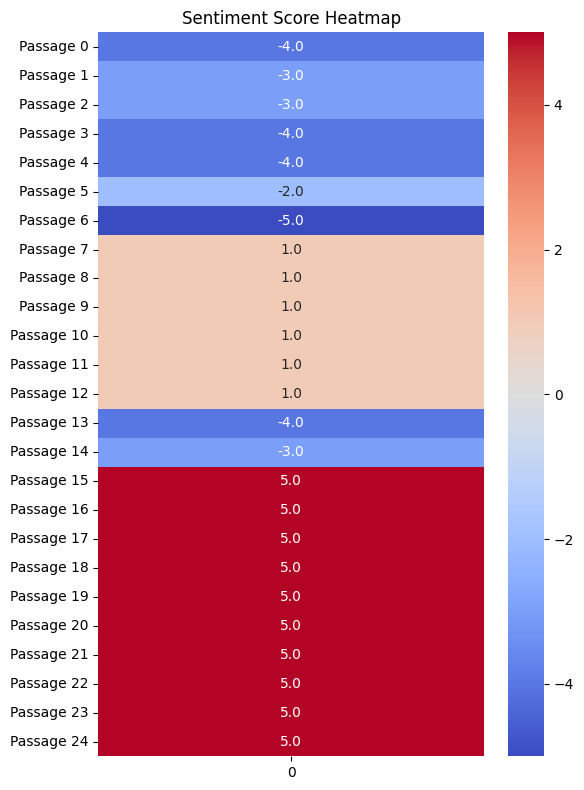

In [ ]:
sentiment_matrix = np.array(passage_sentiments).reshape(-1, 1)
plt.figure(figsize=(6, 8))
sns.heatmap(sentiment_matrix, annot=True, cmap="coolwarm", cbar=True, fmt=".1f", yticklabels=[f"Passage {i}" for i in range(len(passage_sentiments))])
plt.title("Sentiment Score Heatmap")
plt.tight_layout()
plt.show()